In [13]:
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import datapreprocessing as dp
import numpy as np
import pandas as pd
import seaborn as sns
import pickle

# Cross Validation

Do I need a developement set (to find best model) and an evaluation set with data that has not been seen before? -> YES
Do i need to do nested cross vlaidataion? -> NO
Do I need to differenciate between putting in all models and not? -> NO


## Ridge Nested Cross Validation
based on: https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html#sphx-glr-auto-examples-model-selection-plot-nested-cross-validation-iris-py

could potentially do stratified kfold cv https://stackoverflow.com/questions/54945196/sklearn-stratified-k-fold-cv-with-linear-model-like-elasticnetcv



In [3]:
pred, X, velocity_genes, y = dp.get_data(louvain=True)

/home/ubuntu/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


def r2_plot(clf):
    ax = sns.scatterplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_test_r2'], label = 'test')
    sns.scatterplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_train_r2'], label = 'train')
    ax.legend()
    ax.set_title('R2 values against for different alphas')
    ax.set_xlabel('Alpha')
    ax.set_ylabel('R2 value')

def mse_plot(clf):
    sns.lineplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_test_neg_mean_squared_error'])
    sns.lineplot(x=clf.cv_results_['param_alpha'].tolist(), y = clf.cv_results_['mean_train_neg_mean_squared_error'])



In [247]:
def parameter_plot(df, model='', parameter=''):
    ax = sns.histplot(df.loc['best_param'])
    print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                    round(np.std(df.loc['best_param']),4)))
    ax.set_title(model+': Parameter Distribution across all targets')
    ax.set_xlabel(parameter)

In [29]:
def cv_plot(df, model='', parameter='', score='mean_test_r2'):
    for t in df.columns.get_level_values(0).drop_duplicates():
        ax = sns.lineplot(x=df[t].params, y=df[t][score])
    
    # figure out how to print best param. / average out. 
    #print('Average: {} ({})'.format(np.mean(df.loc['best_param']), 
                                    #np.std(df.loc['best_param'])))
    ax.set_title('Parameter Distribution: '+model+parameter)
    ax.set_xlabel(parameter)

In [283]:
# looking at one CV case
def cv_single(df, score, best_param, name, param='param_alpha'):
    splits = [col for col in df.columns if (score in col) & ('split' in col)]
    plt.plot(df[param],df[splits])
    plt.plot(df[param],df['mean_'+score], label='mean', c = 'black')
    plt.axvline(best_param, linestyle='--', color='k',
                label='CV estimate: alpha='+str(best_param))
    plt.legend()
    plt.xlabel('alpha')
    plt.ylabel(score)
    plt.title(name+' CV')

In [251]:
def parameter_r2_plot(df, model='', parameter='', feature='best_param'):

    ax = sns.scatterplot(x = df.loc[feature], y=df.loc['mean_test_r2'])
    ax.set_title('{}: R2 value against best {} for all targets'.format(model, parameter))
    ax.set_xlabel(parameter)
    ax.set_ylabel('mean test R2')
    print('Average {}: {} ({})'.format(parameter, np.mean(df.loc[feature]), 
                                    round(np.std(df.loc[feature]), 4)))
    #print('Average R2 for max_depth 30: {}'.format(df.loc[:,df.loc[feature]==30].loc['mean_test_r2'].mean()))
    #print('Average R2 for max_depth 40: {}'.format(df.loc[:,df.loc[feature]==40].loc['mean_test_r2'].mean()))

In [85]:
# load all cv
import os


def compile_gridsearches_lin(filepath):
    
    best ={}
    best_idx = {}
    
    
    for (dirpath, dirnames, filenames) in os.walk(filepath):
        for name in filenames:
            with open(filepath+name, 'rb') as file:
                gcv = pickle.load(file)
                idx = gcv.best_index_
                
                target, apx = name.split('.')
                best_idx[target] = {'best_param': gcv.cv_results_['param_alpha'][idx],
                                'mean_test_r2': gcv.cv_results_['mean_test_r2'][idx], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'][idx],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'][idx], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'][idx],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'][idx],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'][idx],
                              'std_test_r2': gcv.cv_results_['std_test_r2'][idx],
                              'std_train_r2':gcv.cv_results_['std_train_r2'][idx],
                              }
                
                #'best_param': gcv.cv_results_['param_alpha'],
                best[target]={'params': gcv.cv_results_['param_alpha'],
                            'mean_test_r2': gcv.cv_results_['mean_test_r2'], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'],
                              'std_test_r2': gcv.cv_results_['std_test_r2'],
                              'std_train_r2':gcv.cv_results_['std_train_r2'],
                              }
    return best, best_idx

def reform(dicts):
    return {(outerKey, innerKey): values for outerKey, innerDict in dicts.items() for innerKey, values in innerDict.items()}

In [259]:
def compile_gridsearches_rf(filepath):
    
    best ={}
    best_idx = {}
    
    
    for (dirpath, dirnames, filenames) in os.walk(filepath):
        for name in filenames:
            with open(filepath+name, 'rb') as file:
                gcv = pickle.load(file)
                idx = gcv.best_index_
                
                target, apx = name.split('.')
                best_idx[target] = {'best_param': gcv.cv_results_['param_max_features'][idx],
                                'mean_test_r2': gcv.cv_results_['mean_test_r2'][idx], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'][idx],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'][idx], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'][idx],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'][idx],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'][idx],
                              'std_test_r2': gcv.cv_results_['std_test_r2'][idx],
                              'std_train_r2':gcv.cv_results_['std_train_r2'][idx],
                              }
                
                #'best_param': gcv.cv_results_['param_alpha'],
                best[target]={'params': gcv.cv_results_['param_max_features'],
                            'mean_test_r2': gcv.cv_results_['mean_test_r2'], 
                              'mean_train_r2': gcv.cv_results_['mean_train_r2'],
                              'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'], 
                              'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'],
                              'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'],
                              'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'],
                              'std_test_r2': gcv.cv_results_['std_test_r2'],
                              'std_train_r2':gcv.cv_results_['std_train_r2'],
                              }
    return best, best_idx

Okay, so random forest returns two parameters, which is why i return dict params. --> trouble for later functions.. 

# Lasso

In [207]:
lasso, best_lasso = compile_gridsearches_lin('./model_selection/Lasso(random_state=42)/')

In [211]:
ldf = pd.DataFrame(reform(lasso))
best_ldf = pd.DataFrame(best_lasso)

Average: 0.0006759578233390442 (0.0002)


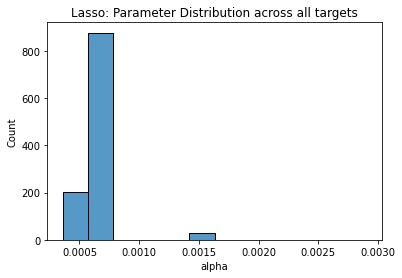

In [252]:
parameter_plot(best_ldf, parameter='alpha', model='Lasso')

Average alpha: 0.0006759578233390442 (0.0002)


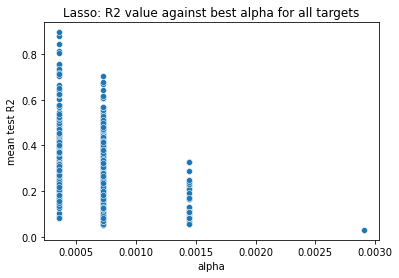

In [253]:
parameter_r2_plot(best_ldf, parameter='alpha', model='Lasso')

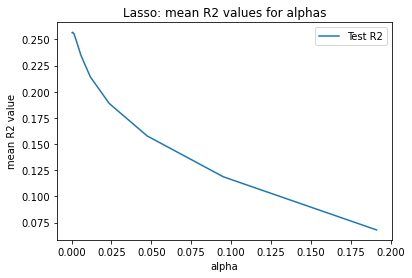

In [244]:
r2_plot_simple(ldf, model='Lasso')

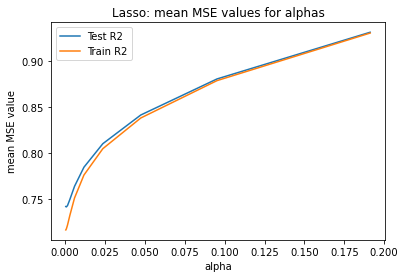

In [216]:
mse_plot(ldf, model='Lasso')

In [324]:
best_ldf.transpose().nsmallest(5, 'mean_test_r2')

,best_param,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Tppp3,0.002906,0.031025,0.064926,-0.845712,-0.829774,0.417039,0.044140,0.050660,0.003885
Nrn1,0.000720,0.050630,0.078687,-0.898299,-0.871176,0.252373,0.027111,0.013819,0.001903
Abi3,0.000720,0.051179,0.083401,-0.972927,-0.941177,0.113064,0.012077,0.013667,0.001401
Calcb,0.001446,0.054903,0.083553,-0.963402,-0.938127,0.231579,0.024627,0.030525,0.003900
H2-Aa,0.001446,0.057670,0.093105,-0.953068,-0.929904,0.399557,0.042653,0.032599,0.003594


In [323]:
best_ldf.transpose().nlargest(5, 'mean_test_r2')

,best_param,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Rasgrp2,0.000358,0.894528,0.897928,-0.104466,-0.101723,0.005496,0.000597,0.008706,0.000955
Nap1l1,0.000358,0.879067,0.883759,-0.120978,-0.117013,0.006412,0.000669,0.010620,0.001108
S100a6,0.000358,0.845325,0.850711,-0.154516,-0.149441,0.009509,0.001027,0.008369,0.000929
Hsp90ab1,0.000358,0.813222,0.820992,-0.182765,-0.177014,0.007936,0.000884,0.018328,0.001933
Malat1,0.000358,0.801745,0.808813,-0.197940,-0.191275,0.009221,0.001045,0.012519,0.001342


In [325]:
a_file = open("/home/ubuntu/volume/model_selection/Lasso(random_state=42)/Tppp3.pkl", "rb")
tpp3 = pickle.load(a_file)

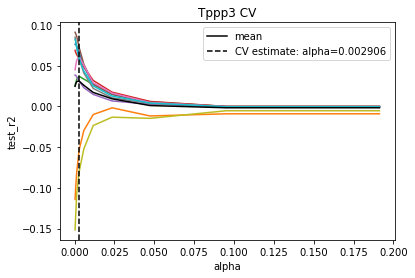

In [330]:
cv_single(pd.DataFrame(tpp3.cv_results_), name='Tppp3', best_param=0.002906, score='test_r2')

In [335]:
a_file = open("/home/ubuntu/volume/model_selection/Lasso(random_state=42)/Rasgrp2.pkl", "rb")
rasgrp2 = pickle.load(a_file)

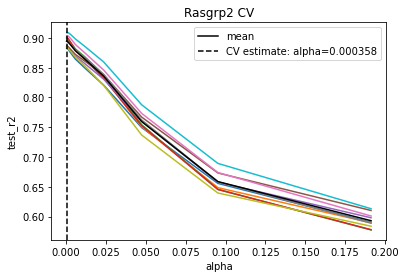

In [336]:
cv_single(pd.DataFrame(rasgrp2.cv_results_), name='Rasgrp2', best_param=0.000358, score='test_r2')

# Random Forest

Random forest lief mit max depth und n_estimators=10 2.24h

In [262]:
rf, best_idx = compile_gridsearches_rf('./model_selection/RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42, max_features=151)/')


In [267]:
rfdf = pd.DataFrame(reform(rf))
best_rfdf = pd.DataFrame(best_idx)

Average : 151.0 (0.0)


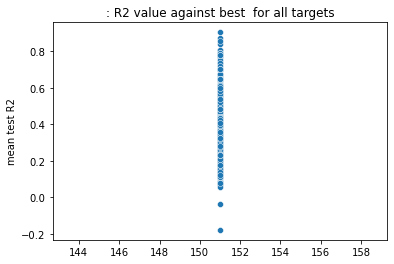

In [272]:
parameter_r2_plot(best_rfdf)

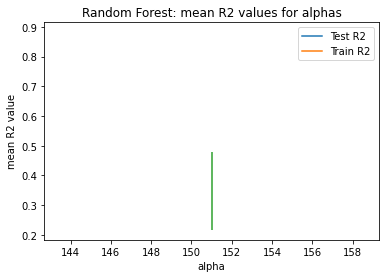

In [274]:
r2_plot(rfdf, model='Random Forest')

In [276]:
best_rfdf.transpose().nlargest(5, 'mean_test_r2')

,best_param,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Rasgrp2,151.0,0.904831,0.982644,-0.094285,-0.017298,0.008639,0.000438,0.010432,0.000434
Nap1l1,151.0,0.870846,0.976367,-0.129430,-0.023792,0.010267,0.000749,0.011380,0.000697
S100a6,151.0,0.856078,0.973513,-0.143568,-0.026514,0.009028,0.000695,0.011021,0.000694
Hsp90ab1,151.0,0.838892,0.970362,-0.157441,-0.029308,0.005937,0.000613,0.017225,0.000654
Ctla2a,151.0,0.808093,0.964332,-0.194400,-0.036287,0.019095,0.001328,0.014247,0.001243


In [277]:
a_file = open("/home/ubuntu/volume/model_selection/RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42, max_features=151)/Tppp3.pkl", "rb")
tpp3 = pickle.load(a_file)

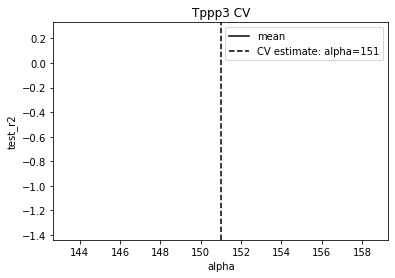

In [290]:
cv_single(pd.DataFrame(tpp3.cv_results_), score='test_r2', best_param=151, name='Tppp3', param='param_max_features')

# Preliminary RF

In [300]:
rf, best_idx = compile_gridsearches_rf('/home/ubuntu/volume/model_selection/RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)_STUPID/')


In [301]:
rfdf = pd.DataFrame(reform(rf))
best_rfdf = pd.DataFrame(best_idx)

Average: 72.77931034482759 (32.6825)


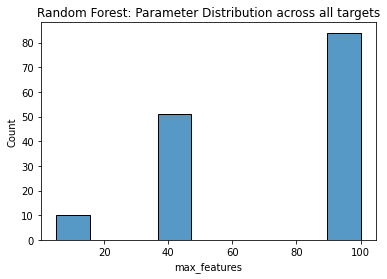

In [312]:
parameter_plot(best_rfdf, model='Random Forest', parameter='max_features')

Average max_features: 72.77931034482759 (32.6825)


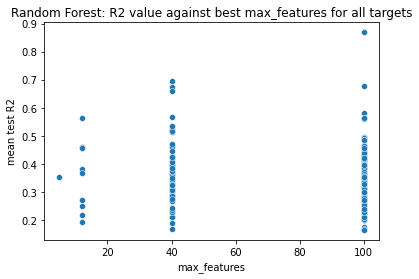

In [313]:
parameter_r2_plot(best_rfdf, model='Random Forest', parameter='max_features')

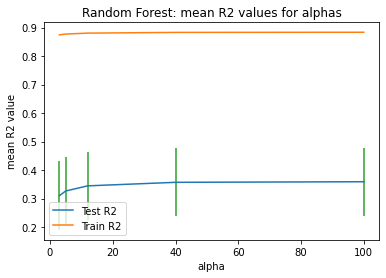

In [316]:
r2_plot(rfdf, model='Random Forest')

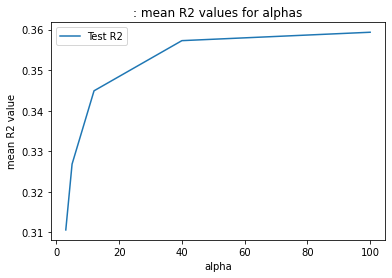

In [319]:
r2_plot_simple(rfdf)

# Ridge

In [86]:
ridge, best_ridge = compile_gridsearches_lin('./model_selection/Ridge(random_state=42)/')

In [88]:
rdf = pd.DataFrame(reform(ridge))
best_rdf = pd.DataFrame(best_ridge)

Average: 45.31605049594229 (21.875425525706312)


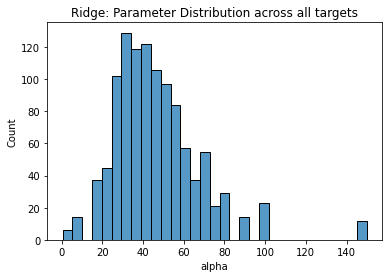

In [102]:
parameter_plot(best_rdf, parameter='alpha', model='Ridge' )

Average alpha: 45.31605049594229 (21.875425525706312)


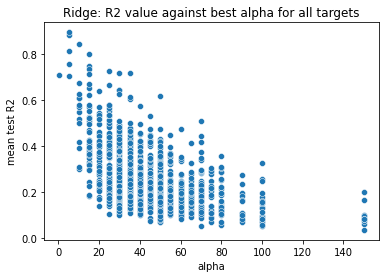

In [103]:
parameter_r2_plot(best_rdf, parameter='alpha', model='Ridge')

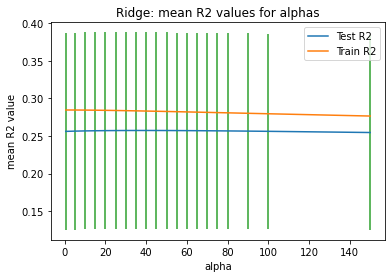

In [241]:
def r2_plot(df, model=''):
    
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), 
                      x=df[('Mcm3', 'params')], label='Test R2')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_r2']].mean(axis=1), 
                 x=df[('Mcm3', 'params')], label='Train R2')
    ax.errorbar(df[('Mcm3', 'params')], df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), 
                yerr=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].std(axis=1), fmt=' ', zorder=-1)
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    
r2_plot(rdf, model='Ridge')

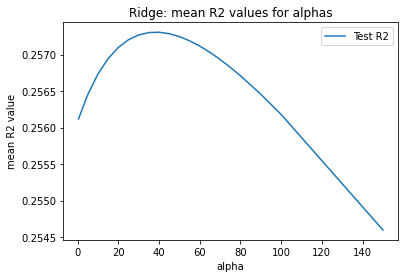

In [240]:
def r2_plot_simple(df, model=''):
    
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_r2']].mean(axis=1), x=df[('Mcm3', 'params')], label='Test R2')
    ax.legend()
    ax.set_title(model+': mean R2 values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean R2 value')
    
r2_plot_simple(rdf, model='Ridge')

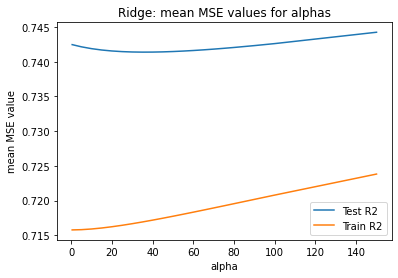

In [132]:
def mse_plot(df, model=''):
    ax = sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_test_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Test R2')
    sns.lineplot(y=df[[idx for idx in df.columns if idx[1]=='mean_train_neg_mean_squared_error']].mean(axis=1)*-1, x=df[('Mcm3', 'params')], label='Train R2')
    ax.legend()
    ax.set_title(model+': mean MSE values for alphas')
    ax.set_xlabel('alpha')
    ax.set_ylabel('mean MSE value')

    
mse_plot(rdf, model='Ridge')

In [190]:
best_rdf.transpose().nsmallest(5, 'mean_test_r2')

,best_param,mean_test_r2,mean_train_r2,mean_test_neg_mean_squared_error,mean_train_neg_mean_squared_error,std_test_neg_mean_squared_error,std_train_neg_mean_squared_error,std_test_r2,std_train_r2
Tppp3,150.0,0.035363,0.076833,-0.837808,-0.819232,0.408217,0.044006,0.060802,0.003420
Nrn1,100.0,0.050844,0.077551,-0.898103,-0.872250,0.252257,0.027151,0.012672,0.001825
Abi3,70.0,0.050976,0.082957,-0.973187,-0.941633,0.113443,0.012116,0.013181,0.001394
Calcb,100.0,0.055433,0.086606,-0.962966,-0.935008,0.231778,0.024767,0.029988,0.003671
Cxxc5,80.0,0.058404,0.087197,-0.909476,-0.882303,0.119528,0.013137,0.015757,0.001634


In [193]:
a_file = open("/home/ubuntu/volume/model_selection/Ridge(random_state=42)/Tppp3.pkl", "rb")
tpp3 = pickle.load(a_file)

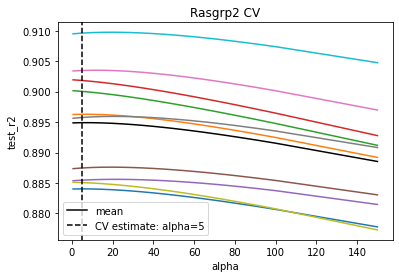

In [218]:
cv_single(rasgrp2_df, name='Rasgrp2', best_param=5, score='test_r2')

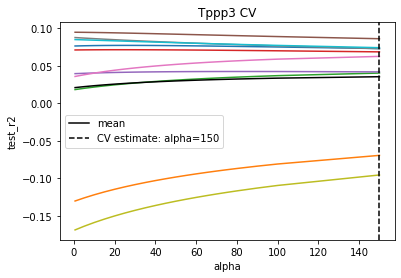

In [202]:
df = pd.DataFrame(tpp3.cv_results_)
cv_single(df, 'test_r2', name='Tppp3', best_param=150)

# Comparing

In [334]:
# Mean
best_ldf.loc['mean_test_r2'].mean()

0.2569463039771395

In [ ]:
bestrdf.loc

In [276]:
df.loc[:,df.loc['best_depth']==30].loc['mean_test_r2'].mean()

0.44525233671753167

Average max_param: 0.001 (0.0)
Average R2: 0.11818754286051239 (0.11184758214268443)
Average R2 for max_param 40: nan
Average R2 for max_param 100: nan


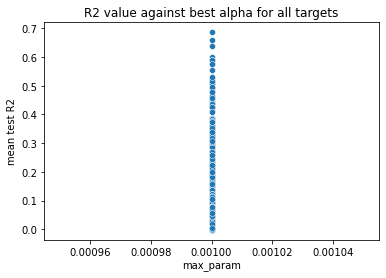

In [85]:
ax = sns.scatterplot(x = df.loc['best_param'], y=df.loc['mean_test_r2'])
ax.set_title('R2 value against best alpha for all targets')
ax.set_xlabel('max_param')
ax.set_ylabel('mean test R2')
print('Average max_param: {} ({})'.format(np.mean(df.loc['best_param']), 
                                np.std(df.loc['best_param'])))
print('Average R2: {} ({})'.format(np.mean(df.loc['mean_test_r2']), 
                                np.std(df.loc['mean_test_r2'])))
print('Average R2 for max_param 40: {}'.format(df.loc[:,df.loc['best_param']==40].loc['mean_test_r2'].mean()))
print('Average R2 for max_param 100: {}'.format(df.loc[:,df.loc['best_param']==100].loc['mean_test_r2'].mean()))

Do clusters here mean anything?

Sind das dieselben gene, die gut vorhersehbar sind bei allen modellen? 

not sure what to do with random forest. 

MSE ->
top genes. 
Are there clusters of genes performing well or good

Irgendwie verwirrt mich das Lasso model. Ist es also doch nicht schlimm dass es nicht konvergiert? Warum ist der kleinste Wert der beste? 

Ridge runs through in 5 mins. THe lasso as well (with parallelization..)

In [238]:
a_file = open("/home/ubuntu/volume/model_selection/RandomForestRegressor(n_jobs=-1, random_state=42)/Mcm3.pkl", "rb")
mcm3 = pickle.load(a_file)

In [241]:
mcm3.best_params_


{'max_depth': 40, 'max_features': 40}

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y['louvain'], test_size = 0.25, shuffle=True, random_state=42)


(0.0002105330773839615,
 0.2646057847522853,
 0.7164464056491852,
 1.1818903625011443)

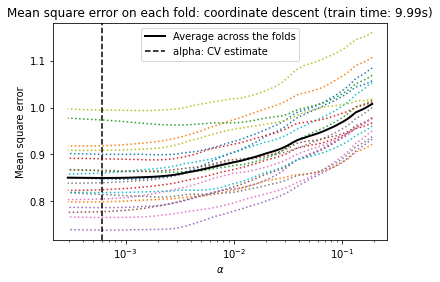

In [60]:
# Display results
plt.figure()
ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
plt.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2438886165618896, tolerance: 0.979430079460144
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7352583408355713, tolerance: 0.979430079460144
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0169262886047363, tolerance: 0.979430079460144
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/line

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2514137029647827, tolerance: 0.9878075122833252
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2522411346435547, tolerance: 0.9878075122833252
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5093305110931396, tolerance: 0.9878075122833252
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/l

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9914093017578125, tolerance: 0.9829444885253906
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1367595195770264, tolerance: 0.9829444885253906
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.707401752471924, tolerance: 0.9829444885253906
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/li

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4037917852401733, tolerance: 0.9854218363761902
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.4186334609985352, tolerance: 0.9854218363761902
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.092732548713684, tolerance: 0.9854218363761902
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/li

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0621767044067383, tolerance: 0.987258791923523
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0780900716781616, tolerance: 0.987258791923523
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.059995174407959, tolerance: 0.987258791923523
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linea

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.100235939025879, tolerance: 0.9849424362182617
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.647059917449951, tolerance: 0.9849424362182617
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.567547082901001, tolerance: 0.9849424362182617
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/line

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2145440578460693, tolerance: 0.9863705635070801
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.603710412979126, tolerance: 0.9863705635070801
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7086210250854492, tolerance: 0.9863705635070801
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/li

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.0480232238769531, tolerance: 0.9837951064109802
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.982640027999878, tolerance: 0.9837951064109802
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3498414754867554, tolerance: 0.9837951064109802
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/li

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7208532094955444, tolerance: 0.9828320145606995
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2278673648834229, tolerance: 0.9828320145606995
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5514063835144043, tolerance: 0.9828320145606995
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/l

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5376970767974854, tolerance: 0.9809064269065857
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.21185040473938, tolerance: 0.9809064269065857
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6740350723266602, tolerance: 0.9809064269065857
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/lin

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2128899097442627, tolerance: 0.9783677458763123
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2246131896972656, tolerance: 0.9783677458763123
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8353216648101807, tolerance: 0.9783677458763123
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/l

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4021010398864746, tolerance: 0.9803256392478943
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.5913000106811523, tolerance: 0.9803256392478943
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3232152462005615, tolerance: 0.9803256392478943
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/l

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.0968971252441406, tolerance: 0.9832097291946411
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3380913734436035, tolerance: 0.9832097291946411
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2187957763671875, tolerance: 0.9832097291946411
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/l

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5366990566253662, tolerance: 0.9850171804428101
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.518768310546875, tolerance: 0.9850171804428101
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.6514641046524048, tolerance: 0.9850171804428101
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/li

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.8487739562988281, tolerance: 0.9849945306777954
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.4183406829833984, tolerance: 0.9849945306777954
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1445116996765137, tolerance: 0.9849945306777954
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/l

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.161561489105225, tolerance: 0.9870868921279907
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3773410320281982, tolerance: 0.9870868921279907
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.045377731323242, tolerance: 0.9870868921279907
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/lin

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.031014919281006, tolerance: 0.975619912147522
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7812745571136475, tolerance: 0.975619912147522
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0495426654815674, tolerance: 0.975619912147522
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linea

/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.039048433303833, tolerance: 0.9859066009521484
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.5332765579223633, tolerance: 0.9859066009521484
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.606903314590454, tolerance: 0.9859066009521484
  model = cd_fast.enet_coordinate_descent_gram(
/home/ubuntu/miniconda3/lib/python3.8/site-packages/sklearn/lin

(2300.0, 3800.0)

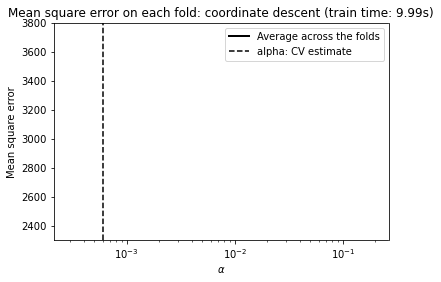

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
import time


EPSILON = 1e-4

t1 = time.time()
model = LassoCV(cv=20).fit(X_train.loc[:, X_train.columns != 'louvain'], 
                                                            y_train.loc[:, 'Aatf'])
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ':')
plt.plot(model.alphas_ + EPSILON, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(model.alpha_ + EPSILON, linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel(r'$\alpha$')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
#plt.ylim(ymin, ymax)


In [80]:
#filenames = ['Pdcd1.pkl', 'Actr3.pkl', 'Stk17b.pkl', 'Mcm6.pkl', 'Tmem163.pkl', 'Ikzf2.pkl', 'Nab1.pkl', 'Ncl.pkl', 'Prim2.pkl', 'Lax1.pkl', 'Mcm3.pkl', 'Fhl2.pkl', 'Smap1.pkl', 'Rev1.pkl', 'Bcl2.pkl', 'Hjurp.pkl', 'Mrpl15.pkl', 'Wdr12.pkl', 'Zranb3.pkl', 'Ikbke.pkl', 'Bard1.pkl', 'Pask.pkl', 'Mybl1.pkl', 'Cd55.pkl', 'Pecr.pkl', 'Aff3.pkl', 'Dyrk3.pkl', '1700019D03Rik.pkl', 'Rgs1.pkl', 'Rgs2.pkl', 'Uck2.pkl', 'Atp2b4.pkl', 'Mndal.pkl', 'BC094916.pkl', 'Tor3a.pkl', 'Gm4955.pkl', 'Pydc4.pkl', 'Capn2.pkl', 'Fasl.pkl', 'Hsd11b1.pkl', 'Map4k4.pkl', 'Dtl.pkl', 'Nuf2.pkl', 'Rrp15.pkl', 'Il18r1.pkl', 'Atp1b1.pkl', 'Smyd2.pkl', 'Cenpf.pkl', 'Wdr75.pkl', 'Il18rap.pkl', 'Stat1.pkl', 'Atf3.pkl', 'Ifi204.pkl', 'Il1r2.pkl', 'Il1rl1.pkl', 'Icos.pkl', 'Sp100.pkl', 'Nop58.pkl', 'Ptma.pkl', 'Rqcd1.pkl', 'Sgol2a.pkl', 'Psmd1.pkl', 'Atic.pkl']
#filenames = ['Pdcd1.pkl', 'Actr3.pkl', 'Stk17b.pkl', 'Mcm6.pkl', 'Ikzf2.pkl', 'Nab1.pkl', 'Tmem163.pkl', 'Ncl.pkl', 'Prim2.pkl', 'Lax1.pkl', 'Fhl2.pkl', 'Smap1.pkl', 'Mcm3.pkl', 'Rev1.pkl', 'Bcl2.pkl', 'Mrpl15.pkl', 'Hjurp.pkl', 'Wdr12.pkl', 'Zranb3.pkl', 'Ikbke.pkl', 'Bard1.pkl', 'Pask.pkl', 'Mybl1.pkl', 'Cd55.pkl', 'Aff3.pkl', 'Pecr.pkl', 'Dyrk3.pkl', '1700019D03Rik.pkl', 'Rgs1.pkl', 'Rgs2.pkl', 'Uck2.pkl', 'Mndal.pkl', 'Atp2b4.pkl', 'Tor3a.pkl', 'Gm4955.pkl', 'BC094916.pkl', 'Pydc4.pkl', 'Capn2.pkl', 'Fasl.pkl', 'Hsd11b1.pkl', 'Dtl.pkl', 'Map4k4.pkl', 'Smyd2.pkl', 'Rrp15.pkl', 'Nuf2.pkl', 'Il18r1.pkl', 'Atp1b1.pkl', 'Cenpf.pkl', 'Wdr75.pkl', 'Il18rap.pkl', 'Stat1.pkl', 'Atf3.pkl', 'Ifi204.pkl', 'Il1r2.pkl', 'Il1rl1.pkl', 'Icos.pkl', 'Nop58.pkl', 'Ptma.pkl', 'Sp100.pkl', 'Rqcd1.pkl', 'Atic.pkl', 'Psmd1.pkl', 'Sgol2a.pkl', 'Nucks1.pkl', 'Nifk.pkl', 'Ube2t.pkl', 'Uchl5.pkl', 'Rgs16.pkl', 'Fam129a.pkl', 'Cd48.pkl', 'Cd244.pkl', 'Pfdn2.pkl', 'Aspm.pkl', 'Kif14.pkl', 'Chit1.pkl', 'Slamf6.pkl', 'Cenpl.pkl', 'Tagln2.pkl', 'Gm10522.pkl', 'Sell.pkl', 'Tnfsf4.pkl', 'Desi2.pkl', 'Pyhin1.pkl', 'Ipcef1.pkl', 'Parp1.pkl', 'Phactr2.pkl', 'Eprs.pkl', 'Exo1.pkl', 'Myb.pkl', 'Ddx21.pkl', 'Slc16a10.pkl', 'Foxo3.pkl', 'Fbxo5.pkl', 'Nsl1.pkl', 'Rpf2.pkl', 'Prdm1.pkl', 'Batf3.pkl', 'Gna15.pkl', 'Hsp90b1.pkl', 'Cdk1.pkl', 'Fzr1.pkl', 'Cct2.pkl', 'Rap1b.pkl', 'Parpbp.pkl', 'Tmpo.pkl', 'Adarb1.pkl', 'Utp20.pkl', 'Pwp2.pkl', 'Nup107.pkl', 'Ifngr1.pkl', 'Pa2g4.pkl', 'Dgka.pkl', 'Gas2l3.pkl', 'Zc3h12d.pkl', 'Nup43.pkl', 'Irak3.pkl', 'Sgk1.pkl', 'Fyn.pkl', 'Hdac2.pkl', 'Prep.pkl', 'Mtfr2.pkl', 'Samd3.pkl', 'Snrpd3.pkl', 'Scml4.pkl', 'Lilrb4a.pkl', 'Tube1.pkl', 'Spock2.pkl', 'Hmha1.pkl', 'Dna2.pkl', 'Palm.pkl', 'Eea1.pkl', 'Ppp1r12a.pkl', 'Ggt1.pkl', 'Atp2b1.pkl', 'Cep83.pkl', '1500009L16Rik.pkl', 'Nap1l1.pkl', 'Pwp1.pkl', 'Egr2.pkl', 'Ptges3.pkl', 'E2f7.pkl', 'Mdm1.pkl', 'Phlda1.pkl', 'Mettl1.pkl', 'Prim1.pkl', 'Timeless.pkl', 'Stat2.pkl', 'Rel.pkl', 'H2afv.pkl', 'Myo1g.pkl', 'Dock2.pkl', 'Npm1.pkl', 'Tbrg4.pkl', 'Ddx56.pkl', 'Canx.pkl', 'Anxa6.pkl', 'Il3.pkl', 'Gemin5.pkl', 'Tmem11.pkl', 'Pfas.pkl', 'Kdm6b.pkl', 'Spdl1.pkl', 'Hmmr.pkl', 'Pelp1.pkl', 'Rap1gap2.pkl', 'Tcf7.pkl', 'Shmt1.pkl', 'Aatf.pkl', 'Luc7l3.pkl', 'Slfn8.pkl', 'Utp18.pkl', 'Brip1.pkl', 'Tada2a.pkl', 'Nle1.pkl', 'Prr11.pkl', 'Top2a.pkl', 'Ikzf3.pkl', 'Cpd.pkl', 'Fam101b.pkl', 'Arl5c.pkl', 'Abi3.pkl', 'Eme1.pkl', 'Pitpnc1.pkl', 'Dhx58.pkl', 'Brca1.pkl', 'Nol11.pkl', 'Ftsj3.pkl', 'Galk1.pkl', 'Pecam1.pkl', 'Srsf2.pkl', 'Tmc6.pkl', 'Mpp2.pkl', 'Adam19.pkl', 'Cbx4.pkl', 'Tk1.pkl', 'Kif18b.pkl', 'Xpo1.pkl', 'Ccm2.pkl', 'Lcp2.pkl', 'G3bp1.pkl', 'Havcr2.pkl', 'Timp2.pkl', 'Larp1.pkl', 'Pik3ip1.pkl', 'Tnfrsf13b.pkl', 'Pik3r5.pkl', 'Slc36a1.pkl', 'Trappc1.pkl', 'Nsg2.pkl', 'Clec10a.pkl', 'Gas7.pkl', 'Suz12.pkl', 'Aurkb.pkl', 'Xaf1.pkl', 'Mettl16.pkl']
filepath = './model_selection/RandomForestRegressor(max_depth=30, n_jobs=-1, random_state=42)/'
rf ={}

for name in filenames:
    with open(filepath+name, 'rb') as file:
        gcv = pickle.load(file)
        idx = gcv.best_index_

        target, apx = name.split('.')

        #'best_depth': gcv.cv_results_['param_max_depth'][idx],
        
        rf[target]={'best_feature': gcv.cv_results_['param_max_features'][idx], 
                      'mean_test_r2': gcv.cv_results_['mean_test_r2'][idx], 
                      'mean_train_r2': gcv.cv_results_['mean_train_r2'][idx],
                      'mean_test_neg_mean_squared_error': gcv.cv_results_['mean_test_neg_mean_squared_error'][idx], 
                      'mean_train_neg_mean_squared_error': gcv.cv_results_['mean_train_neg_mean_squared_error'][idx],
                      'std_test_neg_mean_squared_error': gcv.cv_results_['std_test_neg_mean_squared_error'][idx],
                      'std_train_neg_mean_squared_error': gcv.cv_results_['std_train_neg_mean_squared_error'][idx],
                      'std_test_r2': gcv.cv_results_['std_test_r2'][idx],
                      'std_train_r2':gcv.cv_results_['std_train_r2'][idx],
                      }

In [340]:
(X_train.columns != 'louvain') & (X_train.columns != 'Mcm3')

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [341]:
X_train.loc[:, (X_train.columns != 'louvain') & (X_train.columns != 'Mcm3')]

index,Klf2,Mcm5,Mcm6,Ung,Mndal,Id2,Racgap1,Tbc1d10c,Rgs1,Hsp90b1,...,Sdf2l1,Selplg,Smc2,Smco4,Stmn1,Tnfrsf9,Top2a,Ubc,Vim,Zfp800
index,,,,,,,,,,,,,,,,,,,,,
TACGGGCTCCGAACGC-1-2,0.192700,-0.775276,-0.621701,-0.691457,1.121786,0.086162,2.162536,0.781000,-0.266597,1.833847,...,0.199711,0.399686,0.023977,-1.614014,0.820693,0.180535,-0.376763,-0.692636,0.648390,-0.913863
GCTTGAAAGAAAGTGG-1-3,-0.722739,-0.724819,-0.564661,-0.691457,0.163805,0.251547,-0.627025,2.317778,0.518357,-0.470446,...,-0.604074,-0.061165,-0.750141,-1.287953,-0.630870,-0.187269,-0.433090,0.065072,-0.386361,-0.490332
AGATTGCAGCTAGGCA-1-1,0.350248,-0.828924,-0.675852,-0.691457,-0.029597,-1.204316,-0.272043,0.895650,-0.695362,-1.038326,...,-0.780244,0.850459,-0.689554,1.222219,-0.576560,-0.876542,-0.400944,-0.445555,0.325133,-0.633660
CGAACATGTAAGTGGC-1-2,-0.054215,1.965821,2.348922,1.035332,-0.286336,0.084785,0.031367,-0.032183,-0.390570,-0.093817,...,0.290474,0.007962,0.645253,0.083704,1.535055,0.789256,0.437096,-0.410969,0.478406,0.178482
CGGACACGTAGCTGCC-1-1,0.768150,0.447330,-0.123484,-0.627939,-0.198658,-0.452082,3.287625,-0.028700,-0.713478,0.133225,...,0.000491,0.933490,2.333814,-0.436535,2.016687,-0.340283,2.915191,-0.296416,1.780432,-1.089647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AACCATGAGTATCGAA-1-3,-0.805079,-0.650912,-0.590904,-0.691457,3.282793,1.169071,-0.651473,-1.030435,1.723053,-0.379757,...,-0.512217,-0.203902,-0.509891,-0.676824,-0.572617,-0.316792,-0.612507,1.165431,-0.917964,-2.551565
GACCTGGTCTTCATGT-1-1,0.295252,-0.525237,-0.742474,-0.652149,-0.132241,-0.119045,-0.537758,0.243275,-0.532628,-0.676778,...,-0.475556,0.854963,-0.740394,0.543587,-0.585206,0.134995,-0.591950,-0.572726,1.868678,-0.054557
GGTGCGTCAGCTTCGG-1-2,1.677699,-0.892338,-0.733723,-0.691457,0.204377,-0.175949,0.192242,1.956872,-0.628539,-0.691727,...,-0.558131,2.666960,-0.654861,-1.179511,-0.496539,-0.933141,-0.565436,-0.150776,0.224059,0.655646
